# Imports + device setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import os

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")        # Apple Silicon GPU
    print("Using MPS (Apple GPU)")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using MPS (Apple GPU)


# Load preprocessed data

In [3]:
data_dir = "../preprocessed_data"

X = np.load(os.path.join(data_dir, "X.npy"), mmap_mode='r')
y = np.load(os.path.join(data_dir, "y.npy"))

print("X shape:", X.shape)  # (N, 2, 3000)
print("y shape:", y.shape)

X shape: (414961, 2, 3000)
y shape: (414961,)


# Dataset class

In [4]:
class SleepDataset(Dataset):
    def __init__(self, X, y, indices):
        self.X = X
        self.y = y
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        x = torch.from_numpy(self.X[real_idx].copy()).float()
        y = torch.tensor(self.y[real_idx]).long()

        # Normalize per epoch
        mean = x.mean(dim=1, keepdim=True)
        std  = x.std(dim=1, keepdim=True)
        x = (x - mean) / (std + 1e-6)

        return x, y

# CNN-Transformer architecture

In [5]:
class CNNTransformer(nn.Module):
    def __init__(self, n_channels=2, n_classes=5, embed_dim=128,
                 num_heads=4, num_layers=2, ff_dim=256, dropout=0.1):
        super().__init__()

        # Same CNN as CNN-LSTM for fair comparison
        self.cnn = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, embed_dim, kernel_size=5, padding=2),
            nn.ReLU()
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=False  
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.cnn(x)               # (batch, embed_dim, T')
        x = x.permute(2, 0, 1)        # (T', batch, embed_dim)
        x = self.transformer(x)       # (T', batch, embed_dim)
        x = x.mean(dim=0)             # (batch, embed_dim)
        return self.classifier(x)


# Training + eval functions

In [6]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    losses = []
    all_preds, all_targets = [], []

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='macro')

    return np.mean(losses), acc, f1


def evaluate(model, loader, criterion):
    model.eval()
    losses = []
    all_preds, all_targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            losses.append(loss.item())
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='macro')

    return np.mean(losses), acc, f1, all_preds, all_targets

# Use class weight for highly imbalanced dataset

In [7]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class weights:", class_weights)

Class weights: tensor([0.2908, 3.8562, 1.2005, 6.3649, 3.2124], device='mps:0')


# Perform k-fold cross validation
Checkpoints integrated for resume to handle long training time

In [12]:
import os
import glob

model_dir = "../models"
os.makedirs(model_dir, exist_ok=True)

checkpoint_dir = "../models/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

In [14]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []
all_preds = []
all_targets = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n----- Fold {fold+1} -----")

    # -------------------------
    # Prepare data loaders
    # -------------------------
    train_ds = SleepDataset(X, y, train_idx)
    val_ds   = SleepDataset(X, y, val_idx)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

    # -------------------------
    # Initialize model + optimizer + loss
    # -------------------------
    model = CNNTransformer(n_channels=X.shape[1], n_classes=5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # -------------------------
    # Check for checkpoint and resume if available
    # -------------------------
    checkpoint_pattern = os.path.join(checkpoint_dir, f"transformer_fold{fold+1}_epoch*.pth")
    saved_ckpts = sorted(glob.glob(checkpoint_pattern))

    if len(saved_ckpts) > 0:
        latest_ckpt = saved_ckpts[-1]
        print(f"Resuming from checkpoint: {latest_ckpt}")

        ckpt = torch.load(latest_ckpt, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])

        start_epoch = ckpt["epoch"] + 1
        best_val_f1 = ckpt["best_val_f1"]

    else:
        print("No checkpoint found — starting fresh.")
        start_epoch = 1
        best_val_f1 = 0.0

    best_model_path = os.path.join(model_dir, f"cnn_transformer_fold{fold+1}.pth")

    # -------------------------
    # Training loop with checkpointing
    # -------------------------
    for epoch in range(start_epoch, 21):

        tr_loss, tr_acc, tr_f1 = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc, val_f1, preds, targets = evaluate(model, val_loader, criterion)

        print(f"Epoch {epoch}: "
              f"Train Acc={tr_acc:.3f}, Val Acc={val_acc:.3f}, "
              f"Train F1={tr_f1:.3f}, Val F1={val_f1:.3f}")

        # ---- Save best model for this fold ----
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), best_model_path)
            print(f"New model saved for fold {fold+1} (F1={best_val_f1:.3f})")

        # ---- Save checkpoint for resuming ----
        checkpoint_path = os.path.join(checkpoint_dir, f"transformer_fold{fold+1}_epoch{epoch}.pth")
        checkpoint = {
            "epoch": epoch,
            "fold": fold,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "best_val_f1": best_val_f1
        }

        torch.save(checkpoint, checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")

    # -------------------------
    # Final evaluation using best model
    # -------------------------
    model.load_state_dict(torch.load(best_model_path))
    val_loss, val_acc, val_f1, preds, targets = evaluate(model, val_loader, criterion)

    results.append((val_acc, val_f1))
    all_preds.extend(preds)
    all_targets.extend(targets)



----- Fold 1 -----
No checkpoint found — starting fresh.


/Users/ruoyao.zhang/sleep_stage_classification/venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1: Train Acc=0.811, Val Acc=0.785, Train F1=0.621, Val F1=0.623
New model saved for fold 1 (F1=0.623)
Saved checkpoint: ../models/checkpoints/transformer_fold1_epoch1.pth
Epoch 2: Train Acc=0.849, Val Acc=0.870, Train F1=0.685, Val F1=0.689
New model saved for fold 1 (F1=0.689)
Saved checkpoint: ../models/checkpoints/transformer_fold1_epoch2.pth
Epoch 3: Train Acc=0.860, Val Acc=0.879, Train F1=0.704, Val F1=0.700
New model saved for fold 1 (F1=0.700)
Saved checkpoint: ../models/checkpoints/transformer_fold1_epoch3.pth
Epoch 4: Train Acc=0.865, Val Acc=0.868, Train F1=0.713, Val F1=0.718
New model saved for fold 1 (F1=0.718)
Saved checkpoint: ../models/checkpoints/transformer_fold1_epoch4.pth
Epoch 5: Train Acc=0.867, Val Acc=0.895, Train F1=0.717, Val F1=0.747
New model saved for fold 1 (F1=0.747)
Saved checkpoint: ../models/checkpoints/transformer_fold1_epoch5.pth
Epoch 6: Train Acc=0.869, Val Acc=0.853, Train F1=0.722, Val F1=0.723
Saved checkpoint: ../models/checkpoints/trans

/Users/ruoyao.zhang/sleep_stage_classification/venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1: Train Acc=0.800, Val Acc=0.796, Train F1=0.605, Val F1=0.656
New model saved for fold 2 (F1=0.656)
Saved checkpoint: ../models/checkpoints/transformer_fold2_epoch1.pth
Epoch 2: Train Acc=0.843, Val Acc=0.868, Train F1=0.680, Val F1=0.708
New model saved for fold 2 (F1=0.708)
Saved checkpoint: ../models/checkpoints/transformer_fold2_epoch2.pth
Epoch 3: Train Acc=0.854, Val Acc=0.835, Train F1=0.695, Val F1=0.663
Saved checkpoint: ../models/checkpoints/transformer_fold2_epoch3.pth
Epoch 4: Train Acc=0.860, Val Acc=0.839, Train F1=0.704, Val F1=0.656
Saved checkpoint: ../models/checkpoints/transformer_fold2_epoch4.pth
Epoch 5: Train Acc=0.865, Val Acc=0.877, Train F1=0.712, Val F1=0.738
New model saved for fold 2 (F1=0.738)
Saved checkpoint: ../models/checkpoints/transformer_fold2_epoch5.pth
Epoch 6: Train Acc=0.869, Val Acc=0.871, Train F1=0.720, Val F1=0.722
Saved checkpoint: ../models/checkpoints/transformer_fold2_epoch6.pth
Epoch 7: Train Acc=0.869, Val Acc=0.881, Train F1=0.

/Users/ruoyao.zhang/sleep_stage_classification/venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1: Train Acc=0.811, Val Acc=0.814, Train F1=0.620, Val F1=0.652
New model saved for fold 3 (F1=0.652)
Saved checkpoint: ../models/checkpoints/transformer_fold3_epoch1.pth
Epoch 2: Train Acc=0.848, Val Acc=0.867, Train F1=0.680, Val F1=0.711
New model saved for fold 3 (F1=0.711)
Saved checkpoint: ../models/checkpoints/transformer_fold3_epoch2.pth
Epoch 3: Train Acc=0.854, Val Acc=0.873, Train F1=0.693, Val F1=0.711
New model saved for fold 3 (F1=0.711)
Saved checkpoint: ../models/checkpoints/transformer_fold3_epoch3.pth
Epoch 4: Train Acc=0.855, Val Acc=0.865, Train F1=0.693, Val F1=0.711
Saved checkpoint: ../models/checkpoints/transformer_fold3_epoch4.pth
Epoch 5: Train Acc=0.859, Val Acc=0.847, Train F1=0.701, Val F1=0.701
Saved checkpoint: ../models/checkpoints/transformer_fold3_epoch5.pth
Epoch 6: Train Acc=0.860, Val Acc=0.847, Train F1=0.703, Val F1=0.694
Saved checkpoint: ../models/checkpoints/transformer_fold3_epoch6.pth
Epoch 7: Train Acc=0.859, Val Acc=0.872, Train F1=0.

/Users/ruoyao.zhang/sleep_stage_classification/venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1: Train Acc=0.796, Val Acc=0.834, Train F1=0.596, Val F1=0.685
New model saved for fold 4 (F1=0.685)
Saved checkpoint: ../models/checkpoints/transformer_fold4_epoch1.pth
Epoch 2: Train Acc=0.844, Val Acc=0.841, Train F1=0.677, Val F1=0.663
Saved checkpoint: ../models/checkpoints/transformer_fold4_epoch2.pth
Epoch 3: Train Acc=0.853, Val Acc=0.866, Train F1=0.691, Val F1=0.720
New model saved for fold 4 (F1=0.720)
Saved checkpoint: ../models/checkpoints/transformer_fold4_epoch3.pth
Epoch 4: Train Acc=0.856, Val Acc=0.875, Train F1=0.698, Val F1=0.718
Saved checkpoint: ../models/checkpoints/transformer_fold4_epoch4.pth
Epoch 5: Train Acc=0.862, Val Acc=0.863, Train F1=0.707, Val F1=0.713
Saved checkpoint: ../models/checkpoints/transformer_fold4_epoch5.pth
Epoch 6: Train Acc=0.863, Val Acc=0.874, Train F1=0.711, Val F1=0.740
New model saved for fold 4 (F1=0.740)
Saved checkpoint: ../models/checkpoints/transformer_fold4_epoch6.pth
Epoch 7: Train Acc=0.864, Val Acc=0.852, Train F1=0.

/Users/ruoyao.zhang/sleep_stage_classification/venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1: Train Acc=0.808, Val Acc=0.854, Train F1=0.615, Val F1=0.672
New model saved for fold 5 (F1=0.672)
Saved checkpoint: ../models/checkpoints/transformer_fold5_epoch1.pth
Epoch 2: Train Acc=0.843, Val Acc=0.865, Train F1=0.678, Val F1=0.692
New model saved for fold 5 (F1=0.692)
Saved checkpoint: ../models/checkpoints/transformer_fold5_epoch2.pth
Epoch 3: Train Acc=0.852, Val Acc=0.876, Train F1=0.692, Val F1=0.720
New model saved for fold 5 (F1=0.720)
Saved checkpoint: ../models/checkpoints/transformer_fold5_epoch3.pth
Epoch 4: Train Acc=0.856, Val Acc=0.867, Train F1=0.697, Val F1=0.724
New model saved for fold 5 (F1=0.724)
Saved checkpoint: ../models/checkpoints/transformer_fold5_epoch4.pth
Epoch 5: Train Acc=0.859, Val Acc=0.880, Train F1=0.703, Val F1=0.735
New model saved for fold 5 (F1=0.735)
Saved checkpoint: ../models/checkpoints/transformer_fold5_epoch5.pth
Epoch 6: Train Acc=0.863, Val Acc=0.849, Train F1=0.710, Val F1=0.716
Saved checkpoint: ../models/checkpoints/trans

# Model performance report


Cross-validation summary:
Fold 1: Acc=0.895, F1=0.747
Fold 2: Acc=0.892, F1=0.754
Fold 3: Acc=0.872, F1=0.727
Fold 4: Acc=0.874, F1=0.740
Fold 5: Acc=0.881, F1=0.737
Mean accuracy: 0.8828949892320328
Mean F1: 0.7411969299934709

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    285433
           1       0.34      0.61      0.44     21522
           2       0.87      0.76      0.81     69132
           3       0.70      0.82      0.76     13039
           4       0.69      0.78      0.74     25835

    accuracy                           0.88    414961
   macro avg       0.72      0.78      0.74    414961
weighted avg       0.91      0.88      0.89    414961


Confusion Matrix:


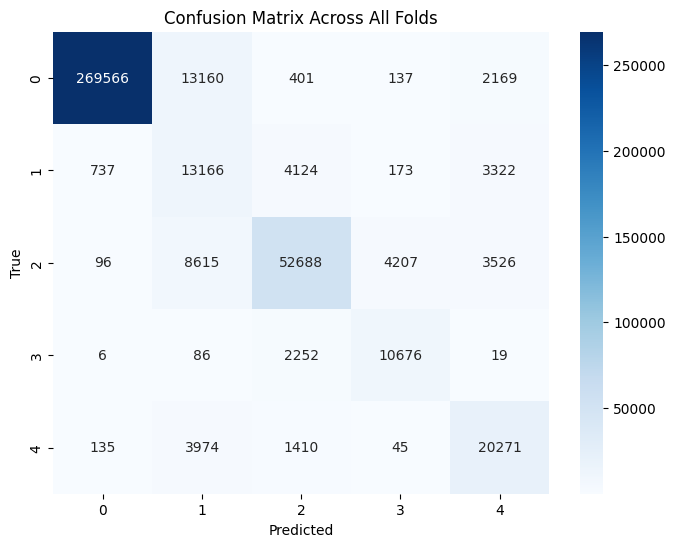

In [15]:
print("\nCross-validation summary:")
for i, (acc, f1) in enumerate(results):
    print(f"Fold {i+1}: Acc={acc:.3f}, F1={f1:.3f}")

print("Mean accuracy:", np.mean([r[0] for r in results]))
print("Mean F1:", np.mean([r[1] for r in results]))


print("\nClassification Report:")
print(classification_report(all_targets, all_preds))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix Across All Folds")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()